# SAM2 Model Training and Inference

This notebook implements GPU-optimized training and inference for Meta SAM2 (Segment Anything Model 2) ([GitHub repo](https://github.com/facebookresearch/sam2)), focusing on segmentation of step recipe images.

**Features**:

- GPU accelerated training with mixed precision
- Model training for point and box prompt types
- Early stopping and checkpoint management
- MLflow experiment tracking
- Inference with point and box prompts
- Visualization of results


### Requirements

In [0]:
!pip install -q --upgrade pip

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
!pip install -U -q mlflow torch torchvision opencv-python pyspark

In [0]:
# Install SAM2 from GitHub repo: https://github.com/facebookresearch/sam2/
%cd sam2
!pip install -e .

<PATH>/RecipeCropper/sam2
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Obtaining file:///<PATH>/RecipeCropper/sam2
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py)

In [0]:
# Check PyTorch + CUDA version
import torch
print(f"PyTorch version: {torch.__version__}")
print("CUDA Version:", torch.version.cuda)
print("Is CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.get_device_name(0))

PyTorch version: 2.5.1+cu124
CUDA Version: 12.4
Is CUDA available: True
Current GPU: Tesla T4


### Dataset

Custom PyTorch dataset for SAM training.It supports two types of prompts:

- **Points**: Generates positive/negative point pairs
- **Boxes**: Creates boinding boxes around objects

In [0]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle
from pathlib import Path
from enum import Enum
import cv2
from torch.utils.data import Dataset, DataLoader

class PromptType(Enum):
    """Supported prompt types."""
    POINTS = "points"
    BOX = "box"
    # MASK = "mask" # TODO

class SAM2Dataset(Dataset):
    """
    Dataset class for SAM-2.
    
    Attributes:
        image_dir: Directory containing input images
        mask_dir: Directory containing segmentation masks
        image_files: List of image filenames
        mask_files: List of corresponding mask filenames
        prompt_type: Prompt type to generate (points or box)
        num_positive_points: Number of positive points for point prompts
        num_negative_points: Number of negative points for point prompts
        augmentation: Whether to apply data augmentation
        target_size: Target size for resizing images and masks
    """
    def __init__(self,
                 image_dir: Path,
                 mask_dir: Path,
                 image_files: list[str] = None,
                 mask_files: list[str] = None,
                 prompt_type: PromptType = PromptType.POINTS,
                 num_positive_points: int = 1,
                 num_negative_points: int = 1,
                 augmentation: bool = False,
                 target_size: int = 1024,
                 ):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.image_files = image_files
        self.mask_files = mask_files
        self.prompt_type = prompt_type
        self.num_positive_points = num_positive_points
        self.num_negative_points = num_negative_points
        self.augmentation = augmentation
        self.target_size = target_size

        # Validate matching files
        if len(self.image_files) != len(self.mask_files):
            raise ValueError(f"Number of images ({len(self.image_files)}) and masks ({len(self.mask_files)}) must match")

    def __len__(self) -> int:
        """Number of samples in the dataset."""
        return len(self.image_files)
    
    def generate_box_prompt(self, mask: np.ndarray) -> np.ndarray:
        """
        Generate bounding box from mask.
        
        Args:
            mask: Binary segmentation mask
        
        Returns:
            Array of [x_min, y_min, x_max, y_max]
        """
        y_indices, x_indices = np.nonzero(mask)
        if len(y_indices) > 0 and len(x_indices) > 0:
            x_min, x_max = np.min(x_indices), np.max(x_indices)
            y_min, y_max = np.min(y_indices), np.max(y_indices)
            # Add small padding
            x_min = max(0, x_min - 35)
            y_min = max(0, y_min - 35)
            x_max = min(mask.shape[1], x_max + 35)
            y_max = min(mask.shape[0], y_max + 35)
            return np.array([[x_min, y_min, x_max, y_max]])
        return np.array([[0, 0, mask.shape[1], mask.shape[0]]])

    def _process_image_and_mask(self, image: np.ndarray, mask: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """
        Resize and pad image and mask to target size.
        
        Args:
            image: Input image of shape (H, W, 3)
            mask: Binary mask of shape (H, W)

        Returns:
            Tuple containing:
                - Processed image of shape (target_size, target_size, 3)
                - Processed mask of shape (target_size, target_size)
        """
        # Calculate resize factor
        r = min(self.target_size / image.shape[1], self.target_size / image.shape[0])
        new_size = (int(image.shape[1] * r), int(image.shape[0] * r))

        # Resize
        image = cv2.resize(image, new_size)
        mask = cv2.resize(mask, new_size, interpolation=cv2.INTER_NEAREST)

        # Pad if needed
        if image.shape[0] < self.target_size or image.shape[1] < self.target_size:
            pad_height = self.target_size - image.shape[0]
            pad_width = self.target_size - image.shape[1]

            image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode="constant")
            mask = np.pad(mask, ((0, pad_height), (0, pad_width)), mode="constant")

        return image, mask
    
    def generate_points(self, mask: np.ndarray) -> np.ndarray:
        """
        Generate positive and negative prompt points from mask, using erosion to avoid boundaries.

        Args:
            mask: Binary segmentation mask
        
        Returns:
            Tuple of (points array, labels array)
                - points: array of shape (N, 2) where N = num_positive + num_negative
                - labels: array of shape (N,) with 1 for positive, 0 for negative
        """
        # Create eroded mask to avoid boundary points
        eroded_mask = cv2.erode(mask, np.ones((5, 5), np.uint8), iterations=1)
        dilated_mask = cv2.dilate(mask, np.ones((5, 5), np.uint8), iterations=2)

        # Get foreground and background coordinates)
        fg_coords = np.argwhere(eroded_mask > 0)
        bg_coords = np.argwhere((dilated_mask == 0) & (mask == 0)) # Background away from boundaries

        points = []
        labels = []

        # Sample positive points
        if len(fg_coords) > 0:
            # Sample points with replacement if we need more points than available coordinates
            pos_indices = np.random.choice(len(fg_coords), size=self.num_positive_points, replace=True)
            for idx in pos_indices:
                yx = fg_coords[idx]
                points.append([yx[1], yx[0]]) # Convert to x,y format
                labels.append(1) # Positive label
        else:
            # Fallback for positive points
            points.extend([[0, 0]] * self.num_positive_points)
            labels.extend([1] * self.num_negative_points)

        # Sample negative points
        if len(bg_coords) > 0:
            # Sample points with replacement if we need more points than available coordinates
            neg_indices = np.random.choice(len(bg_coords), size=self.num_negative_points, replace=True)
            for idx in neg_indices:
                yx = bg_coords[idx]
                points.append([yx[1], yx[0]]) # Convert to x,y format
                labels.append(0) # Negative label
            
        else:
            # Fallback for negative points
            points.extend([[0, 0]] * self.num_negative_points)
            labels.extend([0] * self.num_negative_points)

        return np.array(points), np.array(labels)

    
    def __getitem__(self, idx: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Get a sample from the dataset: image, its mask, prompt points, and point labels.
        
        Args:
            idx: Index of the sample to retrieve
            
        Returns:
            Tuple containing:
                - Image array of shape (H, W, 3)
                - Binary mask array of shape (H, W)
                - Prompt array (points, box, or None depending on prompt_type)
                - Point labels array (only for point prompts, None otherwise)
        """
        # Load image and mask
        image_path = self.image_dir / self.image_files[idx]
        mask_path = self.mask_dir / self.mask_files[idx]

        image = cv2.imread((str(image_path)))[..., ::-1] # BRG to RGB
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)

        # Process image and mask
        image, mask = self._process_image_and_mask(image, mask)

        # Apply augmentation if enabled
        if self.augmentation:
            image, mask = augment(image, mask)

        # Convert mask to binary
        binary_mask = (mask > 0).astype(np.uint8)

        # Generate prompt based on type
        if self.prompt_type == PromptType.POINTS:
            points, point_labels = self.generate_points(binary_mask)
            return (
                image,
                binary_mask.astype(np.float32),
                points.astype(np.float32),
                point_labels.astype(np.float32),
            )
        elif self.prompt_type == PromptType.BOX:
            prompt = self.generate_box_prompt(binary_mask)
            return (
                image, 
                binary_mask.astype(np.float32), 
                prompt.astype(np.float32),
                None # No point labels needed for box
            )
        elif self.prompt_type == PromptType.MASK:
            # Create a slighly modified version of the mask as prompt
            kernel = np.ones((5,5), np.uint8)
            prompt_mask = cv2.dilate(binary_mask, kernel, iterations=1)
            return (
                image,
                binary_mask.astype(np.float32),
                None, # No box
                prompt_mask.astype(np.float32),
            )

    @staticmethod
    def collate_fn(batch) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Collate function for DataLoader.
        
        Args:
            batch: List of tupes (image, mask, points, point_labels)
            
        Returns:
            Tuple containing:
                - Batched images (B, H, W, 3)
                - Batched masks (B, H, W)
                - Batched points (B, N, 2) (if applicable)
                - Batched point labels (B, N) (if applicable)
        """
        images, masks, prompts, labels = zip(*batch)

        # Stack images and target masks
        images = np.stack(images)
        masks = np.stack(masks)

        # Handle different prompt types
        if prompts[0] is not None:
            prompts = np.stack(prompts)
        else:
            prompts = None

        if labels[0] is not None:
            labels = np.stack(labels)
        else:
            labels = None

        return images, masks, prompts, labels

    def visualize_data(self, idx: int, save_path: Path = None) -> None:
        """
        Visualize an image with its mask and prompts (points or box).

        Args:
            idx: Index of the sample to visualize.
            save_path (optional): Path to save the visualization. If None, displays it.
        """
        # Get data
        image, binary_mask, prompt, labels = self[idx] # Calls self.__getitem__(idx)

        # Create figure
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        # Plot original image
        ax1.imshow(image)
        ax1.set_title("Original image")
        ax1.axis("off")

        # Plot binary mask
        ax2.imshow(binary_mask, cmap="gray")
        ax2.set_title("Binary mask")
        ax2.axis("off")

        # Plot mask with prompts
        ax3.imshow(binary_mask, cmap="gray")

        if self.prompt_type == PromptType.POINTS:
            # Plot points in different colors for positive/negative
            for point, label in zip(prompt, labels):
                color = "green" if label == 1 else "red"
                marker = "o" if label == 1 else "x"
                ax3.plot(point[0], point[1], color=color, marker=marker,
                         markersize=10, label="Positive" if label == 1 else "Negative")
            title = "Mask with Points"
                
        elif self.prompt_type == PromptType.BOX:
            # Plot bounding box
            x1, y1, x2, y2 = prompt[0]
            rect = Rectangle((x1, y1), x2-x1, y2-y1,
                             linewidth=2, edgecolor='r', facecolor='none')
            ax3.add_patch(rect)
            title = "Mask with Box"

        # Legend for points only
        if self.prompt_type == PromptType.POINTS:
            handles, labels = ax3.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax3.legend(by_label.values(), by_label.keys())

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
            plt.close()
        else:
            plt.show()

    def visualize_batch(self, batch_size: int = 4, save_dir: Path = None) -> None:
        """
        Visualize a random batch of samples.

        Args:
            batch_size (optional): Number of samples to visualize.
            save_dir (optional): Directory to save visualizations. If None, displays them.
        """
        indices = np.random.choice(len(self), batch_size, replace=False) # Calls self.__len__()

        for i, idx in enumerate(indices):
            if save_dir:
                save_path = save_dir / f"sample_{i}.png"
                save_path.parent.mkdir(parents=True, exist_ok=True)
            else:
                save_path = None
            
            self.visualize_data(idx, save_path)

#### Data Augmentation

In [0]:
import torchvision.transforms as T
from PIL import Image
import numpy as np
import torch
import random

# Data Augmentation
def augment(image: np.ndarray, mask: np.ndarray) -> tuple[Image.Image, Image.Image]:
    """
    Applies data augmentation to an image and its mask.

    Performs the following augmentations in sequence:
        1. Color jitter (image only): Randomly changes brightness, contrast, saturation, and hue.
        2. Random affine transformation: Applies random rotation, translation, scaling, and shearing.
        3. Horizontal flip: Randomly flips the image and mask horizontally.
        4. Vertical flip: Randomfly flips the image and mask vertically.

    Args:
        - image: The input image to be augmented.
        - mask: The corresponding segmentation mask of the input image.

    Returns:
        Tuple with the the augmented (image, mask) pair.
    """
    # Set random seed for reproducibility
    seed = torch.randint(0, 2**32, (1,)).item()
    torch.manual_seed(seed)

    # Convert numpy arays to PIL Images
    image = Image.fromarray(image)
    mask = Image.fromarray(mask.astype(np.uint8))

    # ColorJitter
    color_jitter = T.ColorJitter(
        brightness=0.5,
        contrast=0.5,
        saturation=0.5,
        hue=0.2
    )
    image = color_jitter(image)

    # RandomAffine
    affine = T.RandomAffine(
        degrees=30,
        translate=(0.1, 0.1),
        scale=(0.8, 1.2),
        shear=10
    ) # Set affine params once and apply to both image and mask
    params = affine.get_params(affine.degrees, affine.translate, affine.scale, affine.shear, image.size)
    image = T.functional.affine(image, *params)
    mask = T.functional.affine(mask, *params)

    # Horizontal Flip
    if random.random() > 0.5:
        image = T.functional.hflip(image)
        mask = T.functional.hflip(mask)

    # Vertical Flip
    if random.random() > 0.5:
        image = T.functional.vflip(image)
        mask = T.functional.vflip(mask)

    # Convert back to numpy arrays
    image = np.array(image)
    mask = np.array(mask)

    return image, mask

#### Create Datasets

Note: The datasets created here are for example and visualization purposes only. They will be recreated in the training code below.

In [0]:

from sklearn.model_selection import train_test_split

# Path to dataset
root_dir = Path("<PATH>")
DATASET_DIR = root_dir / "recipe_cropper" / "dataset" / "step" / "dataset_20dec"
img_dir = DATASET_DIR / "images"
mask_dir = DATASET_DIR / "annotations"

# List all image and mask files
VALID_IMAGE_EXTENSIONS = {".png", ".jpg", ".jpeg"}
VALID_MASK_EXTENSIONS = {".png", ".jpg"}
image_files = sorted([f.name for f in img_dir.iterdir() if f.suffix.lower() in VALID_IMAGE_EXTENSIONS])
mask_files = sorted([f.name for f in mask_dir.iterdir() if f.suffix.lower() in VALID_MASK_EXTENSIONS])

# Split data intro train/val/test sets
train_imgs, test_imgs, train_masks, test_masks = train_test_split(image_files, mask_files, test_size=0.1, random_state=42)
train_imgs, valid_imgs, train_masks, valid_masks = train_test_split(train_imgs, train_masks, test_size=0.2, random_state=42)

# Create dataset instances
train_dataset = SAM2Dataset(img_dir, mask_dir, train_imgs, train_masks, num_positive_points=4, num_negative_points=4)
valid_dataset = SAM2Dataset(img_dir, mask_dir, valid_imgs, valid_masks, num_positive_points=4, num_negative_points=4)
test_dataset = SAM2Dataset(img_dir, mask_dir, test_imgs, test_masks, num_positive_points=4, num_negative_points=4)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True, collate_fn=train_dataset.collate_fn, persistent_workers=False)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, num_workers=4, pin_memory=True, collate_fn=train_dataset.collate_fn, persistent_workers=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=4, pin_memory=True, collate_fn=train_dataset.collate_fn, persistent_workers=False)

In [0]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))
print("Number of testing examples:", len(test_dataset))

Number of training examples: 3629
Number of validation examples: 908
Number of testing examples: 505


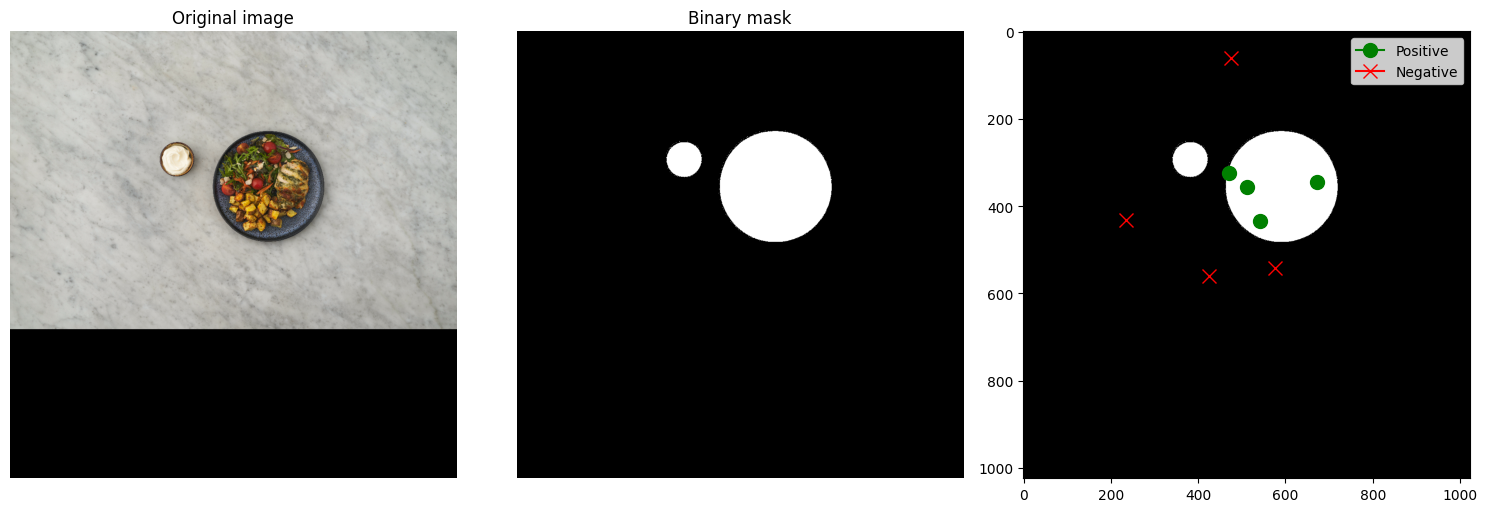

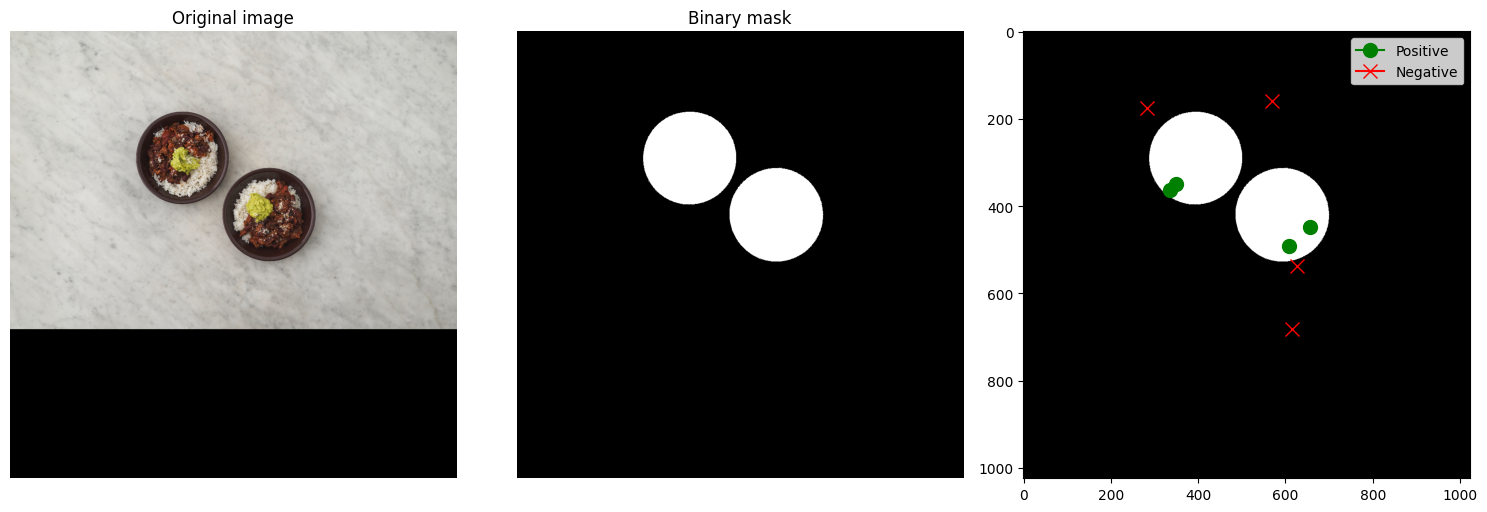

In [0]:
train_dataset.visualize_batch(batch_size=2)

### Train Model

#### Training Functions

Core functions for training SAM. Include:

- `handle_prompts()`: Processes point or box prompts and generates corresponding embeddings
- `train()`: Single epoch training loop iwth mixed precision and gradient clipping
- `evaluate()`: Model evaluation with IoU and loss metrics

In [0]:

from torch.nn.utils import clip_grad_norm_
from torch.cuda.amp import autocast, GradScaler
from sam2.sam2_image_predictor import SAM2ImagePredictor
from tqdm import tqdm

def handle_prompts(model: torch.nn.Module,
                   predictor: SAM2ImagePredictor,
                   prompts: torch.Tensor,
                   labels: torch.Tensor,
                   device: torch.device
                   ) -> tuple[torch.Tensor, torch.Tensor, list[torch.Tensor]]:
    """
    Handle different types of prompts and return embeddings.
    
    Args:
        model: SAM model
        predictor: SAM image predictor
        prompts: Point coordinates or box coordinates
        labels: Point labels (for point prompts only)
        device: Device to train on
        
    Returns:
        Tuple of (sparse_embeddings, dense_embeddings, high_res_features)
    """
    if prompts is None and labels is None:
        raise ValueError("Both prompts and labels cannot be None")
    
    elif prompts is not None and labels is not None:
        # Point prompts
        points = torch.from_numpy(prompts).to(device) # (B, N, 2)
        point_labels = torch.from_numpy(labels).to(device) # (B, N)

        mask_input, unnorm_coords, labels, _ = predictor._prep_prompts(
        points, # (B, N, 2)
        point_labels.unsqueeze(-1), # Add channel dim: (B, N, 1)
        box=None, mask_logits=None, normalize_coords=True
        )

        # Reshape to expected format
        unnorm_coords = unnorm_coords.squeeze(1)  # Remove 2nd dim
        labels = labels.squeeze(1).squeeze(-1)  # Remove 2nd and last dims

        # Get embeddings
        sparse_embeddings, dense_embeddings = model.sam_prompt_encoder(
            points=(unnorm_coords, labels),
            boxes=None,
            masks=None,
        )

        # Get high-res features
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]

        return sparse_embeddings, dense_embeddings, high_res_features

    elif prompts is not None:
        # Box prompts
        box = torch.from_numpy(prompts).to(device)

        # Get embeddings
        sparse_embeddings, dense_embeddings = model.sam_prompt_encoder(
            points=None,
            boxes=box,
            masks=None,
        )

        # Get high-res features
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]

        return sparse_embeddings, dense_embeddings, high_res_features
    
    # else:
    #     Mask prompts -- Haven't figured out yet how to make it work

    #     print("\nMask prompts debug:")
    #     print(f"Input labels shape: {labels.shape}")

    #     # Mask prompts
    #     prev_masks = torch.from_numpy(labels).to(device) # labels contains mask in this case
    #     print(f"After to_device: {prev_masks.shape}")

    #     if len(prev_masks.shape) == 3: # [B, H, W]
    #         prev_masks = prev_masks.unsqueeze(1) # [B, 1, H, W]

    #     mask_input, unnorm_coords, labels, _ = predictor._prep_prompts(
    #         point_coords=None,
    #         point_labels=None,
    #         box=None,
    #         mask_logits=prev_masks.float(),
    #         normalize_coords=True
    #     )

    #     print(f"After _prep_prompts:")
    #     print(f"mask_input shape: {mask_input.shape if mask_input is not None else None}")
    #     print(f"unnorm_coords shape: {unnorm_coords.shape if unnorm_coords is not None else None}")
    #     print(f"labels shape: {labels.shape if labels is not None else None}")

    #     # low_res_masks, pred_scores = predictor.predict(
    #     #     point_coords=None,
    #     #     point_labels=None,
    #     #     mask_input=prev_masks.float(),
    #     #     multimask_output=False
    #     # )

    #     #return low_res_masks, pred_scores

    #     # Get embeddings
    #     sparse_embeddings, dense_embeddings = model.sam_prompt_encoder(
    #         points=None,
    #         boxes=None,
    #         masks=mask_input,
    #     )
    #     print(f"Dense embeddings shape: {dense_embeddings.shape}")


    #     # Get high-res features
    #     high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
    #     print(f"High res features shape: {[f.shape for f in high_res_features]}")


    #     return sparse_embeddings, dense_embeddings, high_res_features

def train(model: torch.nn.Module,
          predictor: SAM2ImagePredictor,
          dataloader: DataLoader,
          optimizer: torch.optim.Optimizer,
          device: torch.device,
          scaler: torch.cuda.amp.GradScaler) -> tuple[float, float]:
    """
    Train SAM-2 for one epoch.

    Args:
        model: SAM-2 model
        dataloader: Training DataLoader
        optimizer: Optimizer
        device: Device to train on
        scaler: Grandient scaler for mixed precision

    Returns:
        Tuple of (average loss, mean IoU)
    """
    torch.cuda.empty_cache() # Free GPU memory

    model.train()

    # Enable training for mask decoder and prompt encoder, keep image encoder frozen
    model.sam_mask_decoder.train(True)
    model.sam_prompt_encoder.train(True)
    model.image_encoder.eval()

    total_loss = 0
    mean_iou = 0

    for batch_idx, (images, masks, prompts, labels) in enumerate(tqdm(dataloader)):
        # Move batch to device
        images = list(images)
        masks = torch.from_numpy(masks).to(device)

        # Mixed precision training
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            # Set images and prepare prompts
            predictor.set_image_batch(images)

            # Get predictions based on prompt type
            embeddings = handle_prompts(model, predictor, prompts, labels, device)
            # Point and box prompts
            sparse_embeddings, dense_embeddings, high_res_features = embeddings

            # Generate masks
            low_res_masks, pred_scores, _, _ = model.sam_mask_decoder(
                image_embeddings=predictor._features["image_embed"],
                image_pe=model.sam_prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=True,
                repeat_image=False,
                high_res_features=high_res_features,
                )
            # else:
            #     # Mask prompts -- Haven't figured out yet
            #     low_res_masks, pred_scores = embeddings

            # Process predictions
            pred_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
            pred_masks = torch.sigmoid(pred_masks[:, 0])

            # Calculate segmentation loss (Binary Cross Entropy)
            seg_loss = (-masks * torch.log(pred_masks + 1e-6) - (1 - masks) * torch.log(1 - pred_masks + 1e-6)).mean()

            # Calculate IoU score loss
            intersection = (masks * (pred_masks > 0.5)).sum((1, 2))
            union = masks.sum((1, 2)) + (pred_masks > 0.5).sum((1, 2)) - intersection
            iou = intersection / (union + 1e-6)
            score_loss = torch.abs(pred_scores[:, 0] - iou).mean()

            # Combined loss
            loss = seg_loss + score_loss * 0.05

        # Barckward pass with gradient scaling
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        # Update metrics
        total_loss += loss.item()
        mean_iou = mean_iou * 0.99 + 0.01 * iou.mean().item()

        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx}: Loss = {loss.item():.4f}, IoU = {mean_iou:.4f}")

    return total_loss / len(dataloader), mean_iou

def evaluate(model: torch.nn.Module,
             predictor: SAM2ImagePredictor,
             dataloader: DataLoader,
             device: torch.device) -> tuple[float, float]:
    """
    Evaluate SAM-2 model.

    Args:
        model: SAM-2 model.
        dataloader: Validation/test DataLoader.
        device: Device to evaluate on.
    
    Returns:
        Tuple of (average loss, mean IoU)
    """
    torch.cuda.empty_cache() # Free GPU memory

    model.eval()
    total_loss = 0
    total_iou = 0
    num_samples = 0

    with torch.no_grad(), torch.amp.autocast("cuda"):
        for images, masks, prompts, labels in tqdm(dataloader):
            # Move batch to device
            images = list(images)
            masks = torch.from_numpy(masks).to(device)

            # Forward pass (same as training but without gradient calculation)
            predictor.set_image_batch(images)

            # Get predictions based on prompt type
            embeddings = handle_prompts(model, predictor, prompts, labels, device)
            if isinstance(embeddings, tuple):
                # Point prompts
                sparse_embeddings, dense_embeddings, high_res_features = embeddings

                # Generate masks
                low_res_masks, pred_scores, _, _ = model.sam_mask_decoder(
                    image_embeddings=predictor._features["image_embed"],
                    image_pe=model.sam_prompt_encoder.get_dense_pe(),
                    sparse_prompt_embeddings=sparse_embeddings,
                    dense_prompt_embeddings=dense_embeddings,
                    multimask_output=True,
                    repeat_image=False,
                    high_res_features=high_res_features,
                )
            else:
                # Box or mask prompts
                low_res_masks, pred_scores = embeddings

            # Process predictions and calculate metrics
            pred_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
            pred_masks = torch.sigmoid(pred_masks[:, 0])

            # Calculate IoU
            intersection = (masks * (pred_masks > 0.5)).sum((1, 2))
            union = masks.sum((1, 2)) + (pred_masks > 0.5).sum((1, 2)) - intersection
            batch_iou = (intersection / (union + 1e-6)).mean().item()

            # Calculate loss
            seg_loss = (-masks * torch.log(pred_masks + 1e-6) - (1 - masks) * torch.log(1 - pred_masks + 1e-6)).mean()
            score_loss = torch.abs(pred_scores[:, 0] - batch_iou).mean()
            loss = seg_loss + score_loss * 0.05

            # Update metrics
            total_loss += loss.item() * len(images)
            total_iou += batch_iou * len(images)
            num_samples += len(images)

    return total_loss / num_samples, total_iou / num_samples

#### Early stopping

In [0]:
from sam2.sam2_image_predictor import SAM2ImagePredictor

# Early Stopping
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.

    Args:
        - patience: Epochs to wait after last improvement of the validation metric.
        - delta: Minimum change to qualify as an improvement.
        - mode: Either "min" or "max". "min" stops when metric stops decreasing,
            "max" stops when metric stops increasing. Default: "min".
        - verbose: If True, prints messages for metric improvements. Default: False.

    Example:
        early_stopping = EarlyStopping(patience=5, mode="max", verbose=True)
        for epoch in range(num_epochs):
            val_iou = validate_model()
            early_stopping(val_iou, model, "best_model.pth")
            if early_stopping.early_stop:
                break
    """
    def __init__(self,
                 patience: int = 5,
                 delta: float = 0,
                 mode: str = "min",
                 verbose: bool = True):
        if mode not in ["min", "max"]:
            raise ValueError(f"Mode {mode} is not supported. Use 'min' or 'max'.")

        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.verbose = verbose
        # Metric tracked can be minimized (Loss) or maximized (IoU, F1-Score)
        self.best_score = -float("inf") if self.mode == "max" else float("inf")
        self.early_stop = False
        self.counter = 0
        self.best_epoch = None

    def __call__(self,
                 epoch: int,
                 metric: float,
                 model: SAM2ImagePredictor,
                 optimizer: torch.optim.Optimizer,
                 scheduler: torch.optim.lr_scheduler._LRScheduler,
                 path: Path):
        """
        Checks early stopping conditions and save the model if metric improves.

        Args:
            epoch: Current epoch number
            metric: Current validation metric value
            model: SAM-2 model
            optimizer: Optimizer instance
            scheduler: Learning rate scheduler
            path: Path to save the checkpoint
        """
        score = metric if self.mode == "max" else -metric

        # Check if metric improved
        improvement = False
        if self.mode == "min":
            improvement = score < self.best_score - self.delta
        elif self.mode == "max":
            improvement = score > self.best_score + self.delta

        if self.best_score is None:
            self.best_score = score
            self.best_epoch = epoch
            self.save_checkpoint(epoch, metric, model, optimizer, scheduler, path)
        elif improvement:
            if self.verbose:
                print(f"Validation metric improved ({self.best_score:.4f} --> {score:.4f}). Saving model...")
            self.best_score = score
            self.best_epoch = epoch
            self.save_checkpoint(epoch, metric, model, optimizer, scheduler, path)
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self,
                        epoch: int,
                        metric: float,
                        model: SAM2ImagePredictor,
                        optimizer: torch.optim.Optimizer,
                        scheduler: torch.optim.lr_scheduler._LRScheduler,
                        path: Path):
        """
        Save complete training state when validation metric improves.
        
        Args:
            - metric: Current validation metric value.
            - mmodel: Model to save if metric improves.
            - path: Path to save the model checkpoint.
        """
        path.parent.mkdir(exist_ok=True, parents=True)

        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "metric_value": metric,
            "best_score": self.best_score,
        }

        # Save regular checkpoint
        torch.save(checkpoint, path)

        # Also save as best model if it's the best so far
        best_path = path.parent / "best_model.pt"
        if metric == self.best_score:
            torch.save(checkpoint, best_path)
            print(f"[Best model] Saved best model at epoch {epoch} with metric value: {metric:.4f}")

        if self.verbose:
            print(f"Saved checkpoint at epoch {epoch} with metric value: {metric:.4f}")

    def load_checkpoint(path: Path,
                        model: SAM2ImagePredictor,
                        optimizer: torch.optim.Optimizer,
                        scheduler: torch.optim.lr_scheduler._LRScheduler) -> tuple[int, float]:
        """
        Load a saved checkpoint.

        Returns:
            Tuple of (epoch number, metric value)
        """
        checkpoint = torch.load(path)

        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

        return checkpoint["epoch"], checkpoint["metric_value"]

#### Training pipeline

##### Model checkpoints
- `sam_2_hiera_tiny`: 38.9 MB
- `sam2_hiera_small`: 46 MB
- `sam2_hiera_base_plus`: 80.8 MB
- `sam2_hiera_large`: 224.4	MB

[SAM2 GitHub repo](https://github.com/facebookresearch/sam2?tab=readme-ov-file#sam-2-checkpoints) for more info.

##### Training with a single prompt

Once the dataset is created with a single prompt type, the following functions are used for training:

- `train_sam2()`: Training loop with mixed precision, early stopping, and MLflow tracking
- `test_sam2()`: Model evaluation on test set
- `run_training()`: Pipeline orchestration





In [0]:
# Utility function to track memory usage across CPU/GPU
# Useful for debugging OOM errors

def log_memory_usage():
    """Logs memory usage for debugging."""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / (1024 ** 3)  # in GB
        reserved = torch.cuda.memory_reserved() / (1024 ** 3)  # in GB
        print(f"GPU Memory: Allocated={allocated:.2f}GB, Reserved={reserved:.2f}GB")
    else:
        process = psutil.Process()
        memory_info = process.memory_info()
        rss = memory_info.rss / (1024 ** 3)  # in GB
        print(f"CPU Memory: RSS={rss:.2f}GB")

import gc
gc.collect() # Garbage collect
torch.cuda.empty_cache() # Free GPU memory

In [0]:
import mlflow

def train_sam2(model: torch.nn.Module,
               predictor: SAM2ImagePredictor,
               train_loader: DataLoader,
               val_loader: DataLoader,
               num_epochs: int,
               learning_rate: float,
               device: torch.device,
               checkpoint_dir: Path,
               early_stopping_patience: int = 12,
               resume_from: Path = None) -> None:
    """
    Main training loop for SAM2.

    Args:
        model: SAM2 model
        predictor: SAM2 image predictor
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of training epochs
        learning_rate: Learning rate
        device: Device to run training on
        checkpoint_dir: Path to save checkpoints
        resume_from: Path to load checkpoint from
    """
    print(f"\nStarting training...")
    try:
        # Setup optimizer and scheduler
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=4e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=5, verbose=True)
        #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6) # Cosine learning rate scheduler

        # Initialize early stopping
        early_stopping = EarlyStopping(patience=early_stopping_patience, mode="max", verbose=True)

        # Setup mixed precision training
        scaler = torch.amp.GradScaler()

        # Resume training if specified
        start_epoch = 0
        if resume_from is not None:
            start_epoch, _ = EarlyStopping.load_checkpoint(resume_from, model, optimizer, scheduler)
            print(f"Resumed training from epoch {start_epoch}")

        # Create checkpoint directory
        checkpoint_dir.mkdir(parents=True, exist_ok=True)

        with mlflow.start_run():
            mlflow.log_params({
                "learning_rate": learning_rate,
                "num_epochs": num_epochs,
                "batch_size": train_loader.batch_size,
                "patience": early_stopping.patience,
                "weight_decay": 1e-4,
                "scheduler_patience": 5,
                "scheduler_factor": 0.1,
            })

            for epoch in range(start_epoch, num_epochs):
                print(f"\nEpoch {epoch+1}/{num_epochs}")
                print("-" * 20)
                log_memory_usage() # Debug

                # Training phase
                train_loss, train_iou = train(model, predictor, train_loader, optimizer, device, scaler)

                log_memory_usage() # Debug

                # Validation phase
                val_loss, val_iou = evaluate(model, predictor, val_loader, device)

                log_memory_usage() # Debug

                # Update scheduler
                current_lr = optimizer.param_groups[0]["lr"]
                scheduler.step(val_iou)
                new_lr = optimizer.param_groups[0]["lr"]

                # Log metrics
                metrics = {
                    "train_loss": train_loss,
                    "train_iou": train_iou,
                    "val_loss": val_loss,
                    "val_iou": val_iou,
                    "learning_rate": current_lr,
                }
                mlflow.log_metrics(metrics, step=epoch)

                # Print epoch results
                print(f"\nEpoch {epoch+1} Results:")
                print(f"Train - Loss: {train_loss:.4f}, IoU: {train_iou:.4f}")
                print(f"Val   - Loss: {val_loss:.4f}, IoU: {val_iou:.4f}")
                print(f"Learning Rate: {current_lr:.1e}" + (f" -> {new_lr:.1e}" if new_lr != current_lr else ""))

                # Early stopping check
                checkpoint_path = checkpoint_dir / f"checkpoint_epoch_{epoch}.pt"
                early_stopping(epoch, val_iou, model, optimizer, scheduler, checkpoint_path)

                if early_stopping.early_stop:
                    print(f"Early stopping triggered. best model was at epoch {early_stopping.best_epoch}")
                    break

    except Exception as ex:
        print(f"Error during training: {ex}")
        import traceback
        traceback.print_exc()
        raise

def test_sam2(model: torch.nn.Module,
              predictor: SAM2ImagePredictor,
              test_loader: DataLoader,
              device: torch.device,
              checkpoint_dir: Path) -> None:
    """
    Evaluate model on test set and save results.
    
    Args:
        model: SAM2 model
        predictor: SAM2 image predictor
        test_loader: Test data loader
        device: Device to run training on
        checkpoint_dir: Path to load checkpoint from
        
    Returns:
        Tuple with (test_loss, test_iou) metrics
    """
    print("\nEvaluating on test set...")
    print("~"*20)
    try:
        # Load best model
        best_model_path = checkpoint_dir / "best_model.pt"
        if best_model_path.exists():
            checkpoint = torch.load(best_model_path)
            model.load_state_dict(checkpoint["model_state_dict"])
            print(f"Loaded best model from epoch {checkpoint['epoch']}")
        else:
            print("Warning: No best model checkpoint found!")
            return

        # Evaluate
        model.eval()
        test_loss, test_iou = evaluate(model, predictor, test_loader, device)

        # Results
        results = {
            "test_loss": test_loss,
            "test_iou": test_iou,
            "epoch": checkpoint["epoch"],
        }

        # Save test results with the checkpoint
        checkpoint.update(results)
        torch.save(checkpoint, best_model_path)

        print(f"\nTest Results -- Loss: {test_loss:.4f}, IoU: {test_iou:.4f}")

    except Exception as ex:
        print(f"Error during testing: {ex}")
        import traceback
        traceback.print_exc()
        raise


In [0]:
from sam2.build_sam import build_sam2

MODEL_CONFIGS = {
    "sam2_hiera_tiny": {
        "checkpoint": "../sam2/checkpoints/sam2.1_hiera_tiny.pt",
        "config": "../sam2/configs/sam2.1/sam2.1_hiera_t.yaml"
    },
    "sam2_hiera_small": {
        "checkpoint": "../sam2/checkpoints/sam2.1_hiera_small.pt",
        "config": "../sam2/configs/sam2.1/sam2.1_hiera_s.yaml"
    },
    "sam2_hiera_base_plus": {
        "checkpoint": "../sam2/checkpoints/sam2.1_hiera_base_plus.pt",
        "config": "../sam2/configs/sam2.1/sam2.1_hiera_b+.yaml"
    },
    "sam2_hiera_large": {
        "checkpoint": "../sam2/checkpoints/sam2.1_hiera_large.pt",
        "config": "../sam2/configs/sam2.1/sam2.1_hiera_l.yaml"
    }
}

def run_training():
    """Complete training pipeline."""
    try:
        # 1. Set up paths and configuration
        root_dir = Path("<PATH>")
        CHECKPOINT_DIR  = root_dir / "recipe_cropper" / "checkpoints" / "sam" / "2025_01_23"
        CHECKPOINT_DIR.mkdir(exist_ok=True, parents=True)

        # 2. Training configuration
        config = {
            "model_type": "sam2_hiera_small",
            "num_epochs": 1,
            "batch_size": 4,
            "learning_rate": 1e-5,
            "num_points": 4,
            "early_stopping_patience": 12,
        }

        # 3. Set device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        # 4. Initialize model
        model_info = MODEL_CONFIGS[config["model_type"]]

        sam2_model = build_sam2(model_info["config"], model_info["checkpoint"], device=str(device), jit=False)
        predictor = SAM2ImagePredictor(sam2_model)

        # 5. Create datasets and dataloaders
        # Already created above. We could recreate them agan, but won't for simplicity
        # num_points and batch_size specified before, not using the values in config

        # 6. Train model
        train_sam2(
            model=sam2_model,
            predictor=predictor,
            train_loader=train_dataloader,
            val_loader=valid_dataloader,
            num_epochs=config["num_epochs"],
            learning_rate=config["learning_rate"],
            device=device,
            checkpoint_dir=CHECKPOINT_DIR,
            early_stopping_patience=config["early_stopping_patience"],
        )

        # 7. Evaluate on test set
        test_sam2(
            model=sam2_model,
            predictor=predictor,
            test_loader=test_dataloader,
            device=device,
            checkpoint_dir=CHECKPOINT_DIR,
        )
    except Exception as ex:
        print("An error occurred during run_training: %s", ex)
        raise

In [0]:
run_training()

Using device: cuda

Starting training...


/local_disk0/.ephemeral_nfs/envs/pythonEnv-807ed0d3-8f49-4b13-b42b-dec0d9311439/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/5
--------------------
GPU Memory: Allocated=0.31GB, Reserved=0.32GB


 12%|█▎        | 1/8 [00:03<00:25,  3.58s/it]

Batch 0: Loss = 0.6209, IoU = 0.0012


100%|██████████| 8/8 [00:04<00:00,  1.78it/s]


GPU Memory: Allocated=0.38GB, Reserved=0.74GB


100%|██████████| 2/2 [00:01<00:00,  1.38it/s]


GPU Memory: Allocated=0.38GB, Reserved=0.76GB

Epoch 1 Results:
Train - Loss: 0.1480, IoU: 0.0305
Val   - Loss: 0.6664, IoU: 0.0182
Learning Rate: 1.0e-05
Validation metric improved (-inf --> 0.0182). Saving model...
[Best model] Saved best model at epoch 0 with metric value: 0.0182
Saved checkpoint at epoch 0 with metric value: 0.0182

Epoch 2/5
--------------------
GPU Memory: Allocated=0.38GB, Reserved=0.76GB


 25%|██▌       | 2/8 [00:01<00:04,  1.34it/s]

Batch 0: Loss = 0.0319, IoU = 0.0093


100%|██████████| 8/8 [00:03<00:00,  2.58it/s]


GPU Memory: Allocated=0.38GB, Reserved=0.74GB


100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


GPU Memory: Allocated=0.38GB, Reserved=0.76GB

Epoch 2 Results:
Train - Loss: 0.0787, IoU: 0.0459
Val   - Loss: 0.3992, IoU: 0.4337
Learning Rate: 1.0e-05
Validation metric improved (0.0182 --> 0.4337). Saving model...
[Best model] Saved best model at epoch 1 with metric value: 0.4337
Saved checkpoint at epoch 1 with metric value: 0.4337

Epoch 3/5
--------------------
GPU Memory: Allocated=0.38GB, Reserved=0.76GB


 25%|██▌       | 2/8 [00:01<00:04,  1.29it/s]

Batch 0: Loss = 0.0349, IoU = 0.0055


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]


GPU Memory: Allocated=0.38GB, Reserved=0.75GB


100%|██████████| 2/2 [00:01<00:00,  1.58it/s]


GPU Memory: Allocated=0.38GB, Reserved=0.75GB

Epoch 3 Results:
Train - Loss: 0.0796, IoU: 0.0499
Val   - Loss: 0.1636, IoU: 0.5552
Learning Rate: 1.0e-05
Validation metric improved (0.4337 --> 0.5552). Saving model...
[Best model] Saved best model at epoch 2 with metric value: 0.5552
Saved checkpoint at epoch 2 with metric value: 0.5552

Epoch 4/5
--------------------
GPU Memory: Allocated=0.38GB, Reserved=0.75GB


 25%|██▌       | 2/8 [00:01<00:04,  1.27it/s]

Batch 0: Loss = 0.0326, IoU = 0.0095


100%|██████████| 8/8 [00:03<00:00,  2.60it/s]


GPU Memory: Allocated=0.38GB, Reserved=0.74GB


100%|██████████| 2/2 [00:01<00:00,  1.62it/s]


GPU Memory: Allocated=0.38GB, Reserved=0.74GB

Epoch 4 Results:
Train - Loss: 0.0607, IoU: 0.0553
Val   - Loss: 0.2184, IoU: 0.5421
Learning Rate: 1.0e-05
EarlyStopping counter: 1/12

Epoch 5/5
--------------------
GPU Memory: Allocated=0.38GB, Reserved=0.74GB


 25%|██▌       | 2/8 [00:01<00:04,  1.26it/s]

Batch 0: Loss = 0.0489, IoU = 0.0055


100%|██████████| 8/8 [00:03<00:00,  2.47it/s]


GPU Memory: Allocated=0.38GB, Reserved=0.75GB


100%|██████████| 2/2 [00:01<00:00,  1.55it/s]


GPU Memory: Allocated=0.38GB, Reserved=0.76GB

Epoch 5 Results:
Train - Loss: 0.0926, IoU: 0.0601
Val   - Loss: 0.5003, IoU: 0.5689
Learning Rate: 1.0e-05
Validation metric improved (0.5552 --> 0.5689). Saving model...
[Best model] Saved best model at epoch 4 with metric value: 0.5689
Saved checkpoint at epoch 4 with metric value: 0.5689

Evaluating on test set...
~~~~~~~~~~~~~~~~~~~~


/root/.ipykernel/1487/command-3488706634249161-3127925585:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


Loaded best model from epoch 4


100%|██████████| 2/2 [00:01<00:00,  1.25it/s]



Test Results -- Loss: 0.0276, IoU: 0.7665


##### Training with different prompt types

The following functions are used for training with different prompt types:

- `train_with_prompt_type()`: Handles training for each individual prompt type
- `run_prompt_experiments()`: Orchestrates multiple training runs with different prompt types

In [0]:
def train_with_prompt_type(prompt_type: PromptType,
                           datasets: dict,
                           config: dict,
                           device: torch.device,
                           checkpoint_dir: Path) -> None:
  """
  Train SAM-2 with a specific prompt type.
  
  Args:
    prompt_type: Type of promot (point, box, mask)
    datasets: Dictionary containing train/valid/test datasets
    config: Training configuration with batch_size, num_epochs, learning_rate
    checkpoint_dir: Directory for saving model checkpoints
  """
  try:
    print("="*20)
    print(f"\n{'='*10} Training with prompt: {prompt_type.value.upper()} {'='*10}")

    # Craete dataloaders
    dataloaders = {
      split: DataLoader(
        dataset,
        batch_size=config["batch_size"],
        shuffle=(split == "train"),
        num_workers=4,
        pin_memory=True,
        collate_fn=dataset.collate_fn,
        persistent_workers=True
      ) for split, dataset in datasets.items()
    }

    # Initialize model and predictor
    model_info = MODEL_CONFIGS[config["model_type"]]

    model = build_sam2(config_file=model_info["config"], checkpoint=model_info["checkpoint"], device=device, jit = False)
    predictor = SAM2ImagePredictor(model)

    # Create experiment-specific name and checkpoint directory
    experiment_name = f"SAM2_{prompt_type.value}_prompt"
    experiment_dir = checkpoint_dir / experiment_name

    # Train model
    train_sam2(
      model=model,
      predictor=predictor,
      train_loader=dataloaders["train"],
      val_loader=dataloaders["valid"],
      num_epochs=config["num_epochs"],
      learning_rate=config["learning_rate"],
      device=device,
      checkpoint_dir=experiment_dir,
      early_stopping_patience=config["early_stopping_patience"],
      #experiment_name=experiment_name,
    )

    # Test model
    test_sam2(
      model=model,
      predictor=predictor,
      test_loader=dataloaders["test"],
      device=device,
      checkpoint_dir=experiment_dir,
    )

  except Exception as ex:
    print(f"Error during training with {prompt_type.value} prompts: {ex}")
    raise

In [0]:
def run_prompt_experiments():
    """Run training experiments with different prompt types."""
    try:
        # 1. Set up paths and configuration
        root_dir = Path("<PATH>")
        CHECKPOINT_DIR  = root_dir / "recipe_cropper" / "checkpoints" / "sam" / "2025_01_24" / "base_plus"
        CHECKPOINT_DIR.mkdir(exist_ok=True, parents=True)

        # 2. Training configuration
        config = {
            "model_type": "sam2_hiera_base_plus",
            "num_epochs": 50,
            "batch_size": 16,
            "learning_rate": 1e-4,
            "num_points": 4,
            "early_stopping_patience": 12,
        }

        # 3. Set device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")

        # 4. Create datasets for each prompt type
        # Created in the cell bellow to visualize the data
        
        # 5. Run experiments for each prompt type
        for prompt_type, prompt_datasets in datasets.items():
            train_with_prompt_type(
                prompt_type=prompt_type,
                datasets=prompt_datasets,
                config=config,
                device=device,
                checkpoint_dir=CHECKPOINT_DIR
            )

    except Exception as ex:
        print(f"An error ocurred during prompt experiments: {ex}")
        raise

In [0]:
# 2. Training configuration -- same as above
config = {
    # "model_type": "sam2_hiera_small",
    # "num_epochs": 10,
    # "batch_size": 4,
    # "learning_rate": 1e-5,
    "num_points": 50,
    #"early_stopping_patience": 12,
}

datasets =  {
            PromptType.POINTS: {
                "train": SAM2Dataset(
                    image_dir=img_dir,
                    mask_dir=mask_dir,
                    image_files=train_imgs,
                    mask_files=train_masks,
                    prompt_type=PromptType.POINTS,
                    num_positive_points=config["num_points"],
                    num_negative_points=config["num_points"],
                    augmentation=False
                ),
                "valid": SAM2Dataset(
                    image_dir=img_dir,
                    mask_dir=mask_dir,
                    image_files=train_imgs,
                    mask_files=train_masks,
                    prompt_type=PromptType.POINTS,
                    num_positive_points=4,
                    num_negative_points=4,
                    augmentation=False
                    ),
                "test": SAM2Dataset(
                    image_dir=img_dir,
                    mask_dir=mask_dir,
                    image_files=train_imgs,
                    mask_files=train_masks,
                    prompt_type=PromptType.POINTS,
                    num_positive_points=4,
                    num_negative_points=4,
                    augmentation=False
                ),
            },
            # PromptType.BOX: {
            #     "train": SAM2Dataset(
            #         image_dir=img_dir,
            #         mask_dir=mask_dir,
            #         image_files=train_imgs,
            #         mask_files=train_masks,
            #         prompt_type=PromptType.BOX,
            #         augmentation=False
            #         ),
            #     "valid": SAM2Dataset(
            #         image_dir=img_dir,
            #         mask_dir=mask_dir,
            #         image_files=train_imgs,
            #         mask_files=train_masks,
            #         prompt_type=PromptType.BOX,
            #         augmentation=False
            #         ),
            #     "test": SAM2Dataset(
            #         image_dir=img_dir,
            #         mask_dir=mask_dir,
            #         image_files=test_imgs,
            #         mask_files=test_masks,
            #         prompt_type=PromptType.BOX,
            #         augmentation=False
            #         ),
            # },
            # PromptType.MASK: {
            #     "train": SAM2Dataset(
            #         image_dir=img_dir,
            #         mask_dir=mask_dir,
            #         image_files=train_imgs,
            #         mask_files=train_masks,
            #         prompt_type=PromptType.MASK,
            #         augmentation=False
            #         ),
            #     "valid": SAM2Dataset(
            #         image_dir=img_dir,
            #         mask_dir=mask_dir,
            #         image_files=train_imgs,
            #         mask_files=train_masks,
            #         prompt_type=PromptType.MASK,
            #         augmentation=False
            #         ),
            #     "test": SAM2Dataset(
            #         image_dir=img_dir,
            #         mask_dir=mask_dir,
            #         image_files=test_imgs,
            #         mask_files=test_masks,
            #         prompt_type=PromptType.MASK,
            #         augmentation=False
            #         ),
            #     }
            }

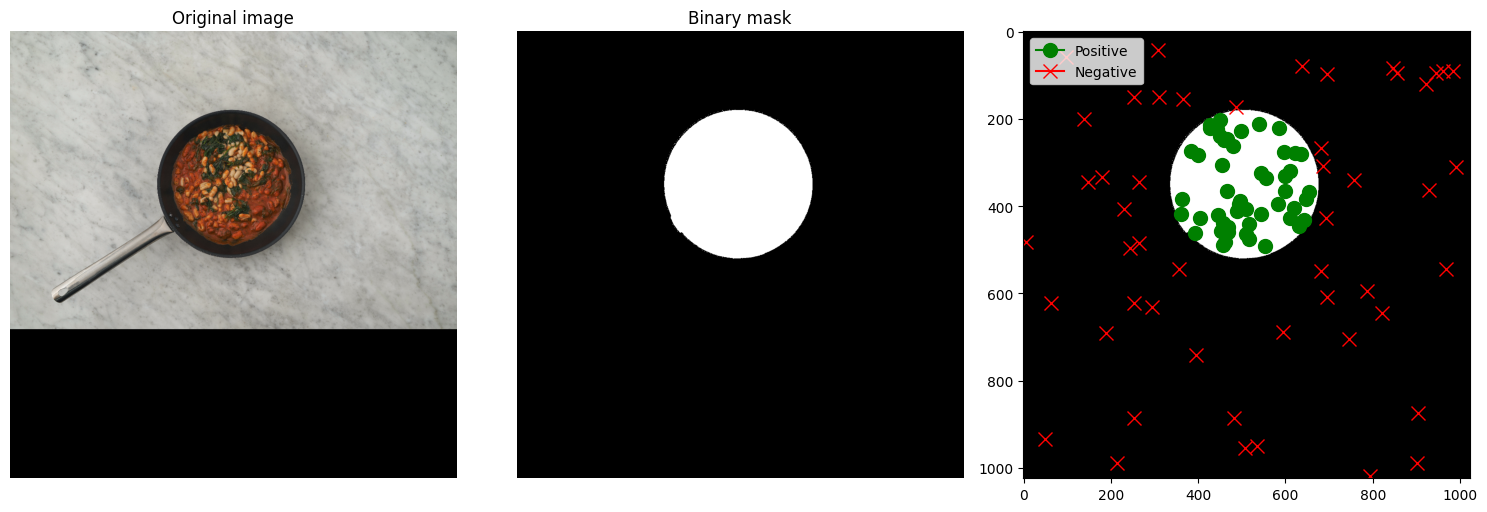

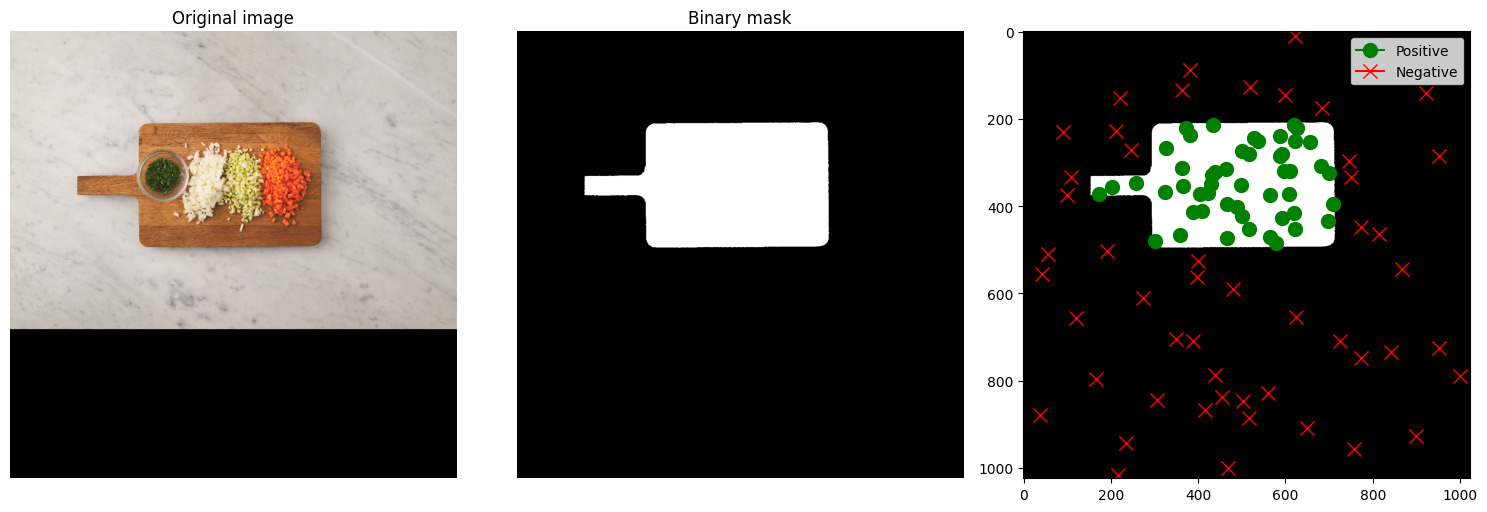

In [0]:
datasets[PromptType.POINTS]["train"].visualize_batch(2)

In [0]:
run_prompt_experiments()

##### Compare experiments

Collects metrics from saved checkpoints and displays comparison in bar plot.

In [0]:
import pandas as pd

def compare_experiments(checkpoint_dir: Path) -> pd.DataFrame:
    """Compare metrics across different prompt types."""
    results = []

    for prompt_dir in checkpoint_dir.glob("SAM2_*_prompt"):
        prompt_type = prompt_dir.name.split("_")[1]
        best_model_path = prompt_dir / "best_model.pt"

        if best_model_path.exists():
            checkpoint = torch.load(best_model_path)
            results.append({
                "prompt_type": prompt_type,
                "best_epoch": checkpoint["epoch"],
                "best_score": checkpoint["best_score"],
                "test_iou": checkpoint["test_iou"]
            })

    return pd.DataFrame(results)

def plot_experiment_results(checkpoint_dir: Path):
    """Compare validation and test IoU across prompt types."""
    fix, ax = plt.subplots(figsize=(10, 6))

    results_df = compare_experiments(checkpoint_dir)

    prompt_types = results_df["prompt_type"]
    best_epochs = results_df["best_epoch"]
    val_ious = results_df["best_score"]
    test_ious = results_df["test_iou"]

    x = np.arange(len(prompt_types))
    width = 0.35

    # Create bar plots
    val_bars = ax.bar(x - width/2, val_ious, width, label="Validation IoU")
    test_bars = ax.bar(x + width/2, test_ious, width, label="Test IoU")

    # Add value labels on top of bars
    for bars in [val_bars, test_bars]:
        for bar in bars:
            height= bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height, f"{height:.4f}", ha="center", va="bottom")

    # Add epoch texts
    for i, epoch in enumerate(best_epochs):
        ax.text(i, 1, f"Epoch: {epoch}", ha="center", va="top")

    ax.set_title("IoU Performance by Prompt Type")
    ax.set_xticks(x)
    ax.set_xticklabels(prompt_types)
    ax.set_ylabel("IoU")
    ax.legend()

    plt.tight_layout()
    plt.show()

/root/.ipykernel/2087/command-3488706634249622-2633006565:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


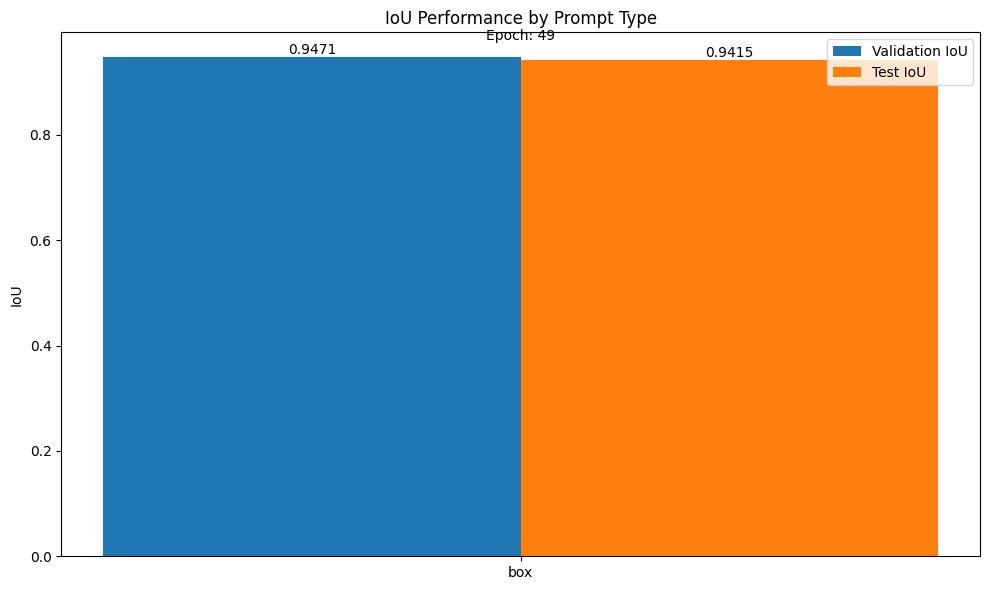

In [0]:
root_dir = Path("<PATH>")
CHECKPOINT_DIR  = root_dir / "recipe_cropper" / "checkpoints" / "sam" / "2025_01_23" / "base_plus"

plot_experiment_results(CHECKPOINT_DIR)

### Inference

- `SAM2Inferencer`: Handles model initialization and inference operations:

  - Loads base and finetuned models
  - Processes images and generates prompt points
  - Provides visualization tools

- `run_inference()`: Orchestrates the complete inference pipeline:

  1. Initializes SAM2 model
  2. Preprocesses images/mask inputs
  3. Generates prompt points
  4. Runs prediction
  5. Visualizes results

In [0]:
from pathlib import Path
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
from sam2.build_sam import build_sam2

class SAM2Inferencer:
    """Class for SAM-2 inference with visualization capabilities."""

    def __init__(self,
                 model_path: Path,
                 config_path: Path,
                 checkpoint_path: Path,
                 device: torch.device = None):
        """
        Initialize SAM-2 model and predictor.
        
        Args:
            model_path: Path to base SAM-2 model
            config_path: path to SAM-2 config file
            checkpoint_path: Path to fine-tuned checkpoints
            device: Device to run inference on
        """
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Initialize model
        self.model = build_sam2(
            config_file=str(config_path),
            checkpoint_path=str(model_path), # Base SAM-2 model
            device=str(self.device)
            )
        
        # Load fine-tuned weights if provided
        if checkpoint_path and checkpoint_path.exists():
            try:
                # Load checkpoint dictionary (because it includes several things)
                checkpoint = torch.load(checkpoint_path, map_location=self.device)

                # Load model weights from checkpoint
                self.model.load_state_dict(checkpoint["model_state_dict"])

                print(f"Loaded fine-tuned weights from: {checkpoint_path}")
                print(f"Checkpoint info:")
                print(f"- Epoch: {checkpoint['epoch']}")
                print(f"- Metric value: {checkpoint['metric_value']:.4f}")
                print(f"- Best score: {checkpoint['best_score']:.4f}")

            except Exception as ex:
                print(f"Error loading fine-tuned checkpoint: {ex}")
                print("Using base model weights only.")

        # Create predictor
        self.predictor = SAM2ImagePredictor(self.model)

        # Enable mixed precision for efficiency
        self.autocast_context = torch.amp.autocast(
            device_type="cuda",
            dtype=torch.bfloat16
        ) if self.device.type == "cuda" else None

    def preprocess_image(self,
                         image_path: Path,
                         mask_path: Path = None,
                         target_size: int = 1024) -> tuple[np.ndarray, np.ndarray]:
        """
        Preprocess image and optional mask.

        Args:
            image_path: Path to input image
            mask_path: Optional path to mask image
            target_size: Target size for resizing

        Returns:
            Tuple of processed image and mask (mask is None if not provided)
        """
        # Read and check image
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Failed to load image: {image_path}")
        image = image[..., ::-1] # BGR to RGB

        # Read mask if provided
        mask = None
        if mask_path is not None:
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise ValueError(f"Failed to load mask: {mask_path}")

        # Calculate resize factor
        r = min(target_size / image.shape[1], target_size / image.shape[0])
        new_size = (int(image.shape[1] * r), int(image.shape[0] * r))

        # Resize image and mask
        image = cv2.resize(image, new_size)
        if mask is not None:
            mask = cv2.resize(mask, new_size, interpolation=cv2.INTER_NEAREST)

        return image, mask
    
    def generate_points(self,
                        mask: np.ndarray,
                        num_positive_points: int = 30,
                        num_negative_points: int = 30) -> np.ndarray:
        """
        Generate positive and negative prompt points.
        
        Args:
            mask: Binary mask where > 0 is foreground
            num_positive_points: Number of positive points to sample from foreground
            num_negative_points: Number of negative points to sample from background
            
        Returns:
            Tuple of (points array, labels array)
                - points: array of shape (N, 1, 2) where N = num_positive + num_negative_points
                - labels: array of shape (N, 1) with 1 for positive, 0 for num_negative_points
        """
        points = []
        labels = []

        # Create eroded mask for reliable foreground point sampling
        eroded_mask = cv2.erode(mask, np.ones((5, 5), np.uint8), iterations=1)
        # Create dilated mask for reliable background point sampling
        dilated_mask = cv2.dilate(mask, np.ones((5, 5), np.uint8), iterations=2)

        # Get foreground coordinates (from eroded mask for more reliable points)
        fg_coords = np.argwhere(eroded_mask > 0)
        if len(fg_coords) > 0:
            # Sample positive points
            for _ in range(num_positive_points):
                idx = np.random.randint(len(fg_coords))
                yx = fg_coords[idx]
                points.append([[yx[1], yx[0]]]) # Convert to x,y format
                labels.append([1]) # Positive label
        else:
            print("Warning: No foreground pixels found in eroded mask.")

        # Get background coordinates (outside dilated mask)
        bg_coords = np.argwhere((dilated_mask == 0) & (mask == 0)) # Background away from boundaries
        if len(bg_coords) > 0:
            # Sample negative points
            for _ in range(num_negative_points):
                idx = np.random.randint(len(bg_coords))
                yx = bg_coords[idx]
                points.append([[yx[1], yx[0]]]) # Convert to x,y format
                labels.append([0]) # Negative label
        else:
            print("Warning: No background pixels found")

        if not points: # If no points were generated
            raise ValueError("Could not generate any points from mask")

        return np.array(points), np.array(labels)
    
    def predict(self,
                image: np.ndarray,
                points: np.ndarray, 
                point_labels: np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Run inference with SAM-2

        Args:
            image: RGB image array
            points: Point coordinates of shape (N, 1, 2)
            point_labels: Point labels of shape (N, 1), 1 for foreground, 0 for background

        Returns:
            Tuple of (masks, scores, logits) for model prediction
        """
        context = self.autocast_context if self.autocast_context else nullcontext()

        with torch.no_grad(), context:
            self.predictor.set_image(image)
            masks, scores, logits = self.predictor.predict(
                point_coords=points,
                point_labels=point_labels
            )

        return masks, scores, logits
    
    def process_predictions(self,
                            masks: np.ndarray,
                            scores: np.ndarray,
                            overlap_threshold: float = 0.15) -> np.ndarray:
        """
        Process predictions into a segmentation map.

        Args:
            masks: Predicted mask array
            scores: Confidence scores for masks
            overlap_threshold: Maximum overlap for combining masks
        
        Returns:
            Segmentation map with unique integers for each instance.
        """
        # Sort masks by score
        masks = masks[:, 0].astype(bool)
        sorted_masks = masks[np.argsort(scores[:, 0])][::-1].astype(bool)

        # Initialize maps
        seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
        occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

        # Combne masks
        for i, mask in enumerate(sorted_masks):
            if (mask * occupancy_mask).sum() / mask.sum() > overlap_threshold:
                continue
            mask_bool = mask.astype(bool)
            mask_bool[occupancy_mask] = False
            seg_map[mask_bool] = i + 1
            occupancy_mask[mask_bool] = True

        return seg_map
    
    def combine_predictions(self,
                            masks: np.ndarray,
                            scores: np.ndarray) -> np.ndarray:
        """
        Combine multiple predictions to get a single foreground mask.
        
        Args:
            masks: Predicted mask array
            scores: Confidence scores for masks

        Returns:
            Combined binary mask
        """
        # Convert predictions to binary
        pred_masks = masks[:, 0] > 0.5

        # Combine all predicted masks into one
        combined_mask = np.zeros_like(pred_masks[0], dtype=np.uint8)
        for mask, score in zip(pred_masks, scores[:, 0]):
            combined mask |= mask.astype(np.uint8)

        # Optional: clean up the mask
        kernel = np.ones((3, 3), np.uint8)
        combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)

        return combined_mask
    
    def visualize_results(self,
                          image: np.ndarray,
                          original_mask: np.ndarray,
                          seg_map: np.ndarray,
                          save_dir: Path = None):
        """
        Visualize or save prediction results.
        
        Args:
            image: Input RGB image
            original_mask (optional): Ground truth mask
            seg_map: Predicted segmentation map
            save_dir (optional): Directory to save visualizations 
        """
        # Create colores segmentation map
        rgb_map = np.zeros((*seg_map.shape, 3), dtype=np.uint8)
        for i in range(1, seg_map.max() + 1):
            rgb_map[seg_map == i] = [
                np.random.randint(255),
                np.random.randint(255),
                np.random.randint(255)
            ]

        # Create visualization
        plt.figure(figsize=(18, 6))

        # Original image
        plt.subplot(131)
        plt.title("Input image")
        plt.imshow(image)
        plt.axis("off")

        # Original mask if available
        plt.subplot(132)
        plt.title("Original Mask" if original_mask is not None else "Segmentation Map")
        plt.imshow(original_mask if original_mask is not None else seg_map, cmap="gray")
        plt.axis("off")

        # Overlay
        plt.subplot(133)
        plt.title("Overlay")
        plt.imshow(cv2.addWeighted(image, 0.7, rgb_map, 0.3, 0))
        plt.axis("off")

        plt.tight_layout()

        # Save or show
        if save_dir:
            save_dir.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_dir / "visualization.png")
            cv2.imwrite(str(save_dir / "segmentation.png"), seg_map)
            cv2.imwrite(str(save_dir / "overlay.png"), cv2.addWeighted(image, 0.7, rgb_map, 0.3, 0))
            plt.close()
        else:
            plt.show()

    def visualize_results_v2(self,
                     image: np.ndarray,
                     original_mask: np.ndarray,
                     seg_map: np.ndarray,
                     points: np.ndarray = None,
                     point_labels: np.ndarray = None,
                     save_dir: Path = None) -> None:
        """
        Visualize inference results with points and segmentation.

        Args:
            image: RGB input image
            original_mask: Original binary mask if available
            seg_map: Predicted segmentation map
            points: Point coordinates used for prompting
            point_labels: Labels for the points (1 for positive, 0 for negative)
            save_dir: Optional directory to save visualizations
        """
        # Create colored segmentation map
        rgb_map = np.zeros((*seg_map.shape, 3), dtype=np.uint8)
        for i in range(1, seg_map.max() + 1):
            rgb_map[seg_map == i] = [
                np.random.randint(255),
                np.random.randint(255),
                np.random.randint(255)
            ]
        
        # Create overlay
        overlay = cv2.addWeighted(image, 0.7, rgb_map, 0.3, 0)
        
        # Create visualization
        fig = plt.figure(figsize=(20, 10))
        
        # First row: Original data and predictions
        plt.subplot(231)
        plt.title('Input Image')
        plt.imshow(image)
        if points is not None and point_labels is not None:
            # Plot points with different colors and markers
            points = points.squeeze(1)  # Remove extra dimension
            for point, label in zip(points, point_labels):
                color = 'lime' if label == 1 else 'red'
                marker = 'o' if label == 1 else 'x'
                plt.plot(point[0], point[1], color=color, marker=marker, 
                        markersize=10, markeredgewidth=2,
                        label='Positive' if label == 1 else 'Negative')
            # Remove duplicate labels in legend
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys())
        plt.axis('off')
        
        plt.subplot(232)
        plt.title('Original Mask' if original_mask is not None else 'No Ground Truth')
        if original_mask is not None:
            plt.imshow(original_mask, cmap='gray')
        plt.axis('off')
        
        plt.subplot(233)
        plt.title('Predicted Segmentation')
        plt.imshow(seg_map, cmap='nipy_spectral')
        plt.axis('off')
        
        # Second row: Different visualizations of results
        plt.subplot(234)
        plt.title('Colored Segmentation')
        plt.imshow(rgb_map)
        plt.axis('off')
        
        plt.subplot(235)
        plt.title('Overlay')
        plt.imshow(overlay)
        plt.axis('off')
        
        plt.subplot(236)
        plt.title('Segmentation Boundaries')
        plt.imshow(image)
        # Plot segmentation boundaries
        for i in range(1, seg_map.max() + 1):
            mask = seg_map == i
            contours, _ = cv2.findContours((mask).astype(np.uint8), 
                                        cv2.RETR_EXTERNAL, 
                                        cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                contour = contour.squeeze()
                if len(contour.shape) > 1:  # Check if valid contour
                    plt.plot(contour[:, 0], contour[:, 1], 
                            color='white', linewidth=2)
                    plt.plot(contour[:, 0], contour[:, 1], 
                            color='red', linewidth=1)
        plt.axis('off')
        
        plt.tight_layout()
        
        # Save or show
        if save_dir:
            save_dir = Path(save_dir)
            save_dir.mkdir(parents=True, exist_ok=True)
            
            # Save main visualization
            plt.savefig(save_dir / "full_visualization.png", 
                    bbox_inches='tight', dpi=300)
            
            # Save individual results
            cv2.imwrite(str(save_dir / "segmentation_map.png"), seg_map)
            cv2.imwrite(str(save_dir / "colored_segmentation.png"), rgb_map)
            cv2.imwrite(str(save_dir / "overlay.png"), overlay)
            
            plt.close()
        else:
            plt.show()

In [0]:
# Inference with POINTS

def run_inference_points(
    image_path: Path,
    mask_path: Path,
    model_path: Path,
    config_path: Path,
    checkpoint_path: Path,
    save_dir: Path = None,
    num_positive_points: int = 30,
    num_negative_points: int = 30,
) -> None:
    """
    Run complete inference pipeline using point prompts generate from mask.
    
    Args:
        image_path: Path to input image
        mask_path: Path to mask for generating points
        model_path: Path to SAM2 base model
        config_path: Path to model config
        checkpoint_path: Path to fine-tuned weights
        save_dir (optional): Output directory for visualizations
        num_positive_points: Number of positive points to generate
        num_negative_points: Number of negative points to generate
    """
    try:
        # Initialize inferencer
        inferencer = SAM2Inferencer(model_path, config_path, checkpoint_path)

        # Preprocess inputs
        image, mask = inferencer.preprocess_image(image_path, mask_path)

        # Generate points and labels
        points, point_labels = inferencer.generate_points(
            mask,
            num_positive_points=num_positive_points,
            num_negative_points=num_negative_points
        )

        # Run prediction with positive and negative points
        masks, scores, _ = inferencer.predict(image, points, point_labels)
        seg_map = inferencer.process_predictions(masks, scores)

        # Visualize with points
        inferencer.visualize_results_v2(
            image=image,
            original_mask=mask,
            seg_map=seg_map,
            points=points,
            point_labels=point_labels
        )
    except Exception as ex:
        print(f'Error during inference: {ex}')
        raise

In [0]:
# Inference with BOXES

def run_inference_box(
    image_path: Path,
    model_path: Path,
    config_path: Path,
    checkpoint_path: Path,
    save_dir: Path = None,
    use_fixed_box: bool = True,
) -> None:
    """
    Run complete inference pipeline using box prompts
    
    Args:
        image_path: Path to input image
        model_path: Path to SAM2 base model
        config_path: Path to model config
        checkpoint_path: Path to fine-tuned weights
        save_dir (optional): Output directory for visualizations
        use_fixed_box: Where to use a fixed bounding box size
    """
    try:
        # Initialize inferencer
        inferencer = SAM2Inferencer(model_path, config_path, checkpoint_path)

        # Preprocess inputs
        image, mask = inferencer.preprocess_image(image_path, None)

        # Run prediction with positive and negative points
        masks, scores, _ = inferencer.predict(image, use_fixed_box=use_fixed_box)
        seg_map = inferencer.process_predictions(masks, scores, overlap_threshold=0.20)

        # Visualize with points
        inferencer.visualize_results(
            image=image,
            original_mask=mask,
            seg_map=seg_map,
        )
    except Exception as ex:
        print(f'Error during inference: {ex}')
        raise

In [0]:
MODEL_PATH = Path("../sam2/checkpoints/sam2.1_hiera_tiny.pt")
CONFIG_PATH = Path("../sam2/configs/sam2.1/sam2.1_hiera_t.yaml")
CHECKPOINT_PATH = Path("<PATH>/recipe_cropper/checkpoints/sam/2025_01_20/best_model.pt")
IMAGE_PATH = Path("<PATH>/recipe_cropper/dataset/step/dataset_20dec/images/EP_Y24_R01_W49_AUS_02_1__original.jpg")
MASK_PATH = Path("<PATH>/recipe_cropper/dataset/step/dataset_20dec/annotations/EP_Y24_R01_W49_AUS_02_1__mask.jpg")

run_inference_points(image_path=IMAGE_PATH, mask_path=MASK_PATH, model_path=MODEL_PATH, config_path=CONFIG_PATH, checkpoint_path=CHECKPOINT_PATH)

# Failing because we're passing points, points labels after generating them from generate_points inside run_inference_points
# But if we just change the predict signature to accept the image and num of points with default values, it will work

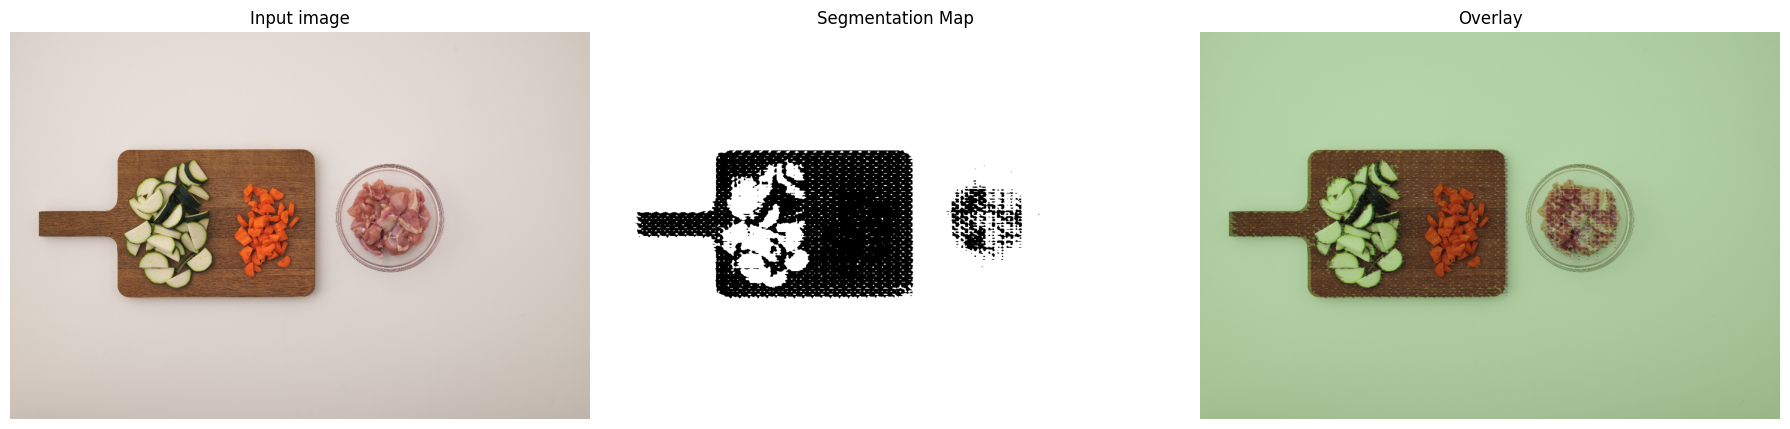

In [0]:
MODEL_PATH = Path("../sam2/checkpoints/sam2.1_hiera_tiny.pt")
CONFIG_PATH = Path("../sam2/configs/sam2.1/sam2.1_hiera_t.yaml")
CHECKPOINT_PATH = Path("<PATH>/recipe_cropper/checkpoints/sam/2025_01_24/base_plus/best_model.pt")
IMAGE_PATH = Path("<PATH>/recipe_cropper/dataset/step/dataset_20dec/images/EP_Y24_R01_W49_AUS_02_1__original.jpg")

run_inference_box(image_path=IMAGE_PATH, model_path=MODEL_PATH, config_path=CONFIG_PATH, checkpoint_path=CHECKPOINT_PATH)
